# Neanderthal ancestry over time &mdash; Ice Age samples

In [1]:
source("../R/process_snp_data.R")


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



## Load the information about samples

In [2]:
sample_info <- load_sample_info("../raw_data/ice_age/individuals")

In [3]:
head(sample_info)

sample_id,sample_name,date,time_after_admix,estimate_nea
Altai,Altai,70000,-15000,FALSE
Denisova,Denisovan,70000,-15000,FALSE
MezE,Mezmaiskaya,70000,-15000,FALSE
Ust_Ishim,UstIshim,45021,9979,TRUE
Vi_merge,Vindija,40000,15000,FALSE
I0908_published,Oase1,39688,15312,FALSE


## Load the SNP table from David and Qiaomei

In [4]:
# order columns by age starting from the oldest sample
snps <- read.table("../clean_data/ice_age.tsv", header=T) %>%
    .[c("chrom", "pos", "bvalue", "phylop", "exon_distance", "exon_overlap", sample_info$sample_id)]

In [5]:
head(snps)

chrom,pos,bvalue,phylop,exon_distance,exon_overlap,Altai,Denisova,MezE,Ust_Ishim,⋯,B_Dinka_3,B_French_3,B_Han_3,Href,B_Karitiana_3,B_Mandenka_3,B_Mbuti_4,B_Papuan_15,B_Sardinian_3,B_Yoruba_3
1,847983,958,-0.1768525737131438,12277,0.07262964,1,0,9,0,⋯,0,0,0,0,0,0,0,0,0,0
1,853089,958,-0.14593803098450783,7171,0.07618462,1,0,9,0,⋯,0,0,0,0,0,0,0,0,0,0
1,853596,958,-0.2523228385807088,6664,0.07618462,1,0,9,0,⋯,0,0,0,0,0,0,0,0,0,0
1,854793,958,-0.2806111944027995,5467,0.07618462,1,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
1,867151,946,-0.26553823088455814,682,0.07874961,1,0,9,0,⋯,0,0,0,0,0,0,0,0,0,0
1,867404,946,-0.2496536731634183,935,0.07874961,1,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0


In [6]:
(snp_total <- nrow(snps))

[1] 783747

## Calculate the number of sites available for each sample

This is done based on David's and Qiaomei's `genosnp` file (i.e. we are calculating for each sample the number of non-9 alleles).

In [7]:
sample_info <- mutate(sample_info, snp_count=snps[sample_info$sample_id] %>%
                                             apply(2, function(sample_snps) { sum(sample_snps != 9) }))

## What is the proportion of alleles matching Altai in different "control" individuals?

These quantities are used for converting raw proportions to actual estimates of Nea. ancestry bellow using David's formula:

$prop_{Test}=\dfrac{E_{Test} - E_{Dinka}}{E_{Mezmaiskaya} - E_{Dinka}}$

Where $E_{X}$ is a proportion of sharing of derived alleles with the Altai Neanderthal in an individual $X$ and $prop_{Test}$ is the converted proportion of Neanderthal ancestry.

In [8]:
(E_dinka <- calc_proportion(snps, "Altai", "B_Dinka_3"))
(E_mez <- calc_proportion(snps, "Altai", "MezE"))
(E_vindija <- calc_proportion(snps, "Altai", "Vi_merge"))

[1] 0.004786519

[1] 0.7624912

[1] 0.77012

## Estimate the amount of Neanderthal ancestry in each sample using block jackknife

Which samples to analyze?

In [15]:
include_samples <- filter(sample_info, estimate_nea) %>% extract2("sample_id")

What number of blocks to use for the jackknife?

In [16]:
n_blocks <- 100

How many bins to partition the SNPs into?

In [17]:
n_bins <- 5

Calculate quantiles of B values that will be used to partition SNPs into bins:

In [18]:
(bcutoffs <- quantile(snps$bvalue, prob=seq(0, 1, 1 / n_bins))[-(n_bins + 1)])

0% 20% 40% 60% 80% 
  0 672 830 906 954

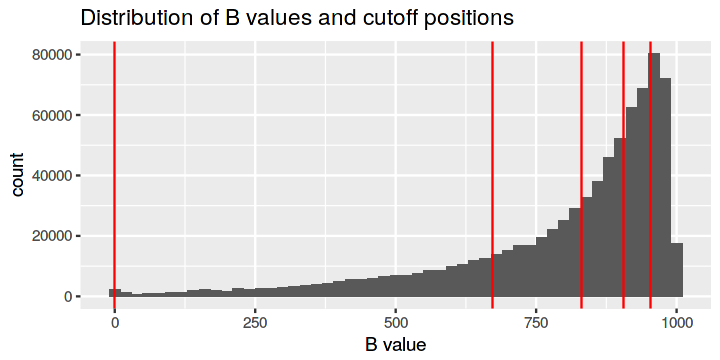

In [21]:
options(repr.plot.width=6, repr.plot.height=3)
qplot(snps$bvalue, binwidth=20, xlab="B value", main="Distribution of B values and cutoff positions")+
    geom_vline(xintercept=bcutoffs, color="red")

## Calculate Neanderthal ancestry % for each sample in each partition

In [18]:
nea_estimates_cumul <- lapply(bcutoffs, function(bcutoff) {
    snps_subset <- filter(snps, bvalue >= bcutoff)

    # calculate Nea% in leave-one-block-out subset of SNPs
    nea_in_partials <- calc_nea_partials(snps_subset, n_blocks, include_samples)

    # calculate mean Nea% in a given set of samples
    mean_nea <- calc_mean_nea(snps_subset, include_samples)
    
    # calculate the Nea% using block jackknife
    jackknife_nea <- calc_jackknife_nea(nea_in_partials, mean_nea)
    
    # merge the Nea% statistics with othe sample information
    inner_join(filter(sample_info, sample_id %in% include_samples),
               jackknife_nea, by="sample_id") %>%
        mutate(bin=bcutoff) %>% return()
})

Concatenate individual data.frames in a list:

In [19]:
nea_estimates_cumul <- Reduce(full_join, nea_estimates_cumul)

Joining by: c("sample_id", "sample_name", "date", "time_after_admix", "estimate_nea", "snp_count", "mean_nea", "mean_partials", "jack_bias", "jack_mean", "jack_se", "jack_ci_low", "jack_ci_up", "paper_ci_low", "paper_ci_up", "bin")
Joining by: c("sample_id", "sample_name", "date", "time_after_admix", "estimate_nea", "snp_count", "mean_nea", "mean_partials", "jack_bias", "jack_mean", "jack_se", "jack_ci_low", "jack_ci_up", "paper_ci_low", "paper_ci_up", "bin")
Joining by: c("sample_id", "sample_name", "date", "time_after_admix", "estimate_nea", "snp_count", "mean_nea", "mean_partials", "jack_bias", "jack_mean", "jack_se", "jack_ci_low", "jack_ci_up", "paper_ci_low", "paper_ci_up", "bin")
Joining by: c("sample_id", "sample_name", "date", "time_after_admix", "estimate_nea", "snp_count", "mean_nea", "mean_partials", "jack_bias", "jack_mean", "jack_se", "jack_ci_low", "jack_ci_up", "paper_ci_low", "paper_ci_up", "bin")


In [20]:
write.table(nea_estimates_cumul, "../results/nea_estimates_cumulative_b.tsv", quote=FALSE, sep="\t", row.names=FALSE)

## Calculate Neanderthal ancestry % for each sample in each bin

In [23]:
(bcutoffs <- c(bcutoffs, 1001))

0%  20%  40%  60%  80%      
   0  672  830  906  954 1001

Counts of SNPs in each partition

In [24]:
findInterval(snps$bvalue, bcutoffs, rightmost.closed=TRUE) %>% table

.
     1      2      3      4      5 
156482 155753 157409 157123 156980 

In [62]:
nea_estimates_bins <- lapply(seq_len(n_bins), function(i) {
    snps_subset <- filter(snps, (bcutoffs[i] < bvalue) & (bvalue < bcutoffs[i + 1]))

    # calculate Nea% in leave-one-block-out subset of SNPs
    nea_in_partials <- calc_nea_partials(snps_subset, n_blocks, include_samples)

    # calculate mean Nea% in a given set of samples
    mean_nea <- calc_mean_nea(snps_subset, include_samples)
    
    # calculate the Nea% using block jackknife
    jackknife_nea <- calc_jackknife_nea(nea_in_partials, mean_nea)
    
    # merge the Nea% statistics with othe sample information
    inner_join(filter(sample_info, sample_id %in% include_samples),
               jackknife_nea, by="sample_id") %>%
        mutate(bin=i - 1) %>% return()
})

Concatenate individual data.frames in a list:

In [63]:
nea_estimates_bins <- Reduce(full_join, nea_estimates_bins)

Joining by: c("sample_id", "sample_name", "date", "time_after_admix", "estimate_nea", "snp_count", "mean_nea", "mean_partials", "jack_bias", "jack_mean", "jack_se", "jack_ci_low", "jack_ci_up", "paper_ci_low", "paper_ci_up", "bin")
Joining by: c("sample_id", "sample_name", "date", "time_after_admix", "estimate_nea", "snp_count", "mean_nea", "mean_partials", "jack_bias", "jack_mean", "jack_se", "jack_ci_low", "jack_ci_up", "paper_ci_low", "paper_ci_up", "bin")
Joining by: c("sample_id", "sample_name", "date", "time_after_admix", "estimate_nea", "snp_count", "mean_nea", "mean_partials", "jack_bias", "jack_mean", "jack_se", "jack_ci_low", "jack_ci_up", "paper_ci_low", "paper_ci_up", "bin")
Joining by: c("sample_id", "sample_name", "date", "time_after_admix", "estimate_nea", "snp_count", "mean_nea", "mean_partials", "jack_bias", "jack_mean", "jack_se", "jack_ci_low", "jack_ci_up", "paper_ci_low", "paper_ci_up", "bin")


In [64]:
write.table(nea_estimates_bins, "../results/nea_estimates_b_bins.tsv", quote=FALSE, sep="\t", row.names=FALSE)

<br><br><br><br><br>
## Plotting the Nea % over time

In [29]:
library(magrittr)
library(dplyr)
library(stringr)
library(ggplot2)

In [75]:
options(repr.plot.width=9, repr.plot.height=5)

In [79]:
nea_estimates_cumul <- read.table("../results/nea_estimates_cumulative_b.tsv", header=TRUE, stringsAsFactors=FALSE)

### Jackknife from the paper

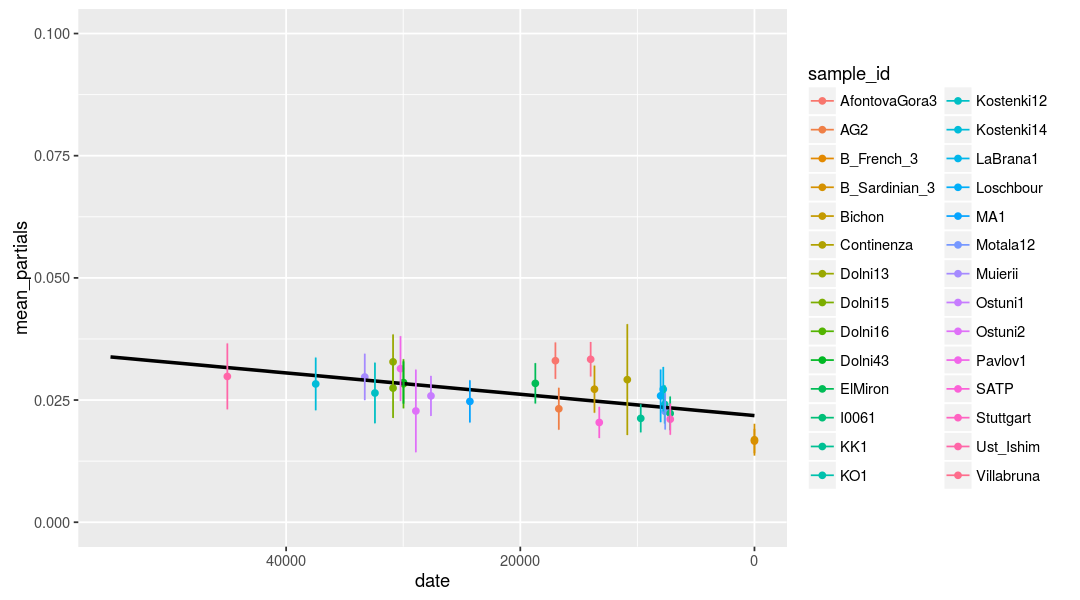

In [76]:
ggplot(filter(nea_estimates_cumul, bin == 0, sample_id != "Oase1_d"), aes(x=date, y=mean_partials, color=sample_id)) +
    geom_point() +
    geom_smooth(method="lm", col="black", se=FALSE, fullrange=TRUE) +
    geom_errorbar(aes(ymin=paper_ci_low, ymax=paper_ci_up)) +
    scale_x_reverse(lim=c(55000, 0)) + 
    ylim(0, 0.1)

## Nea% over time in different B value partitions

In [77]:
options(repr.plot.width=9, repr.plot.height=15)

### Jackknife from the paper

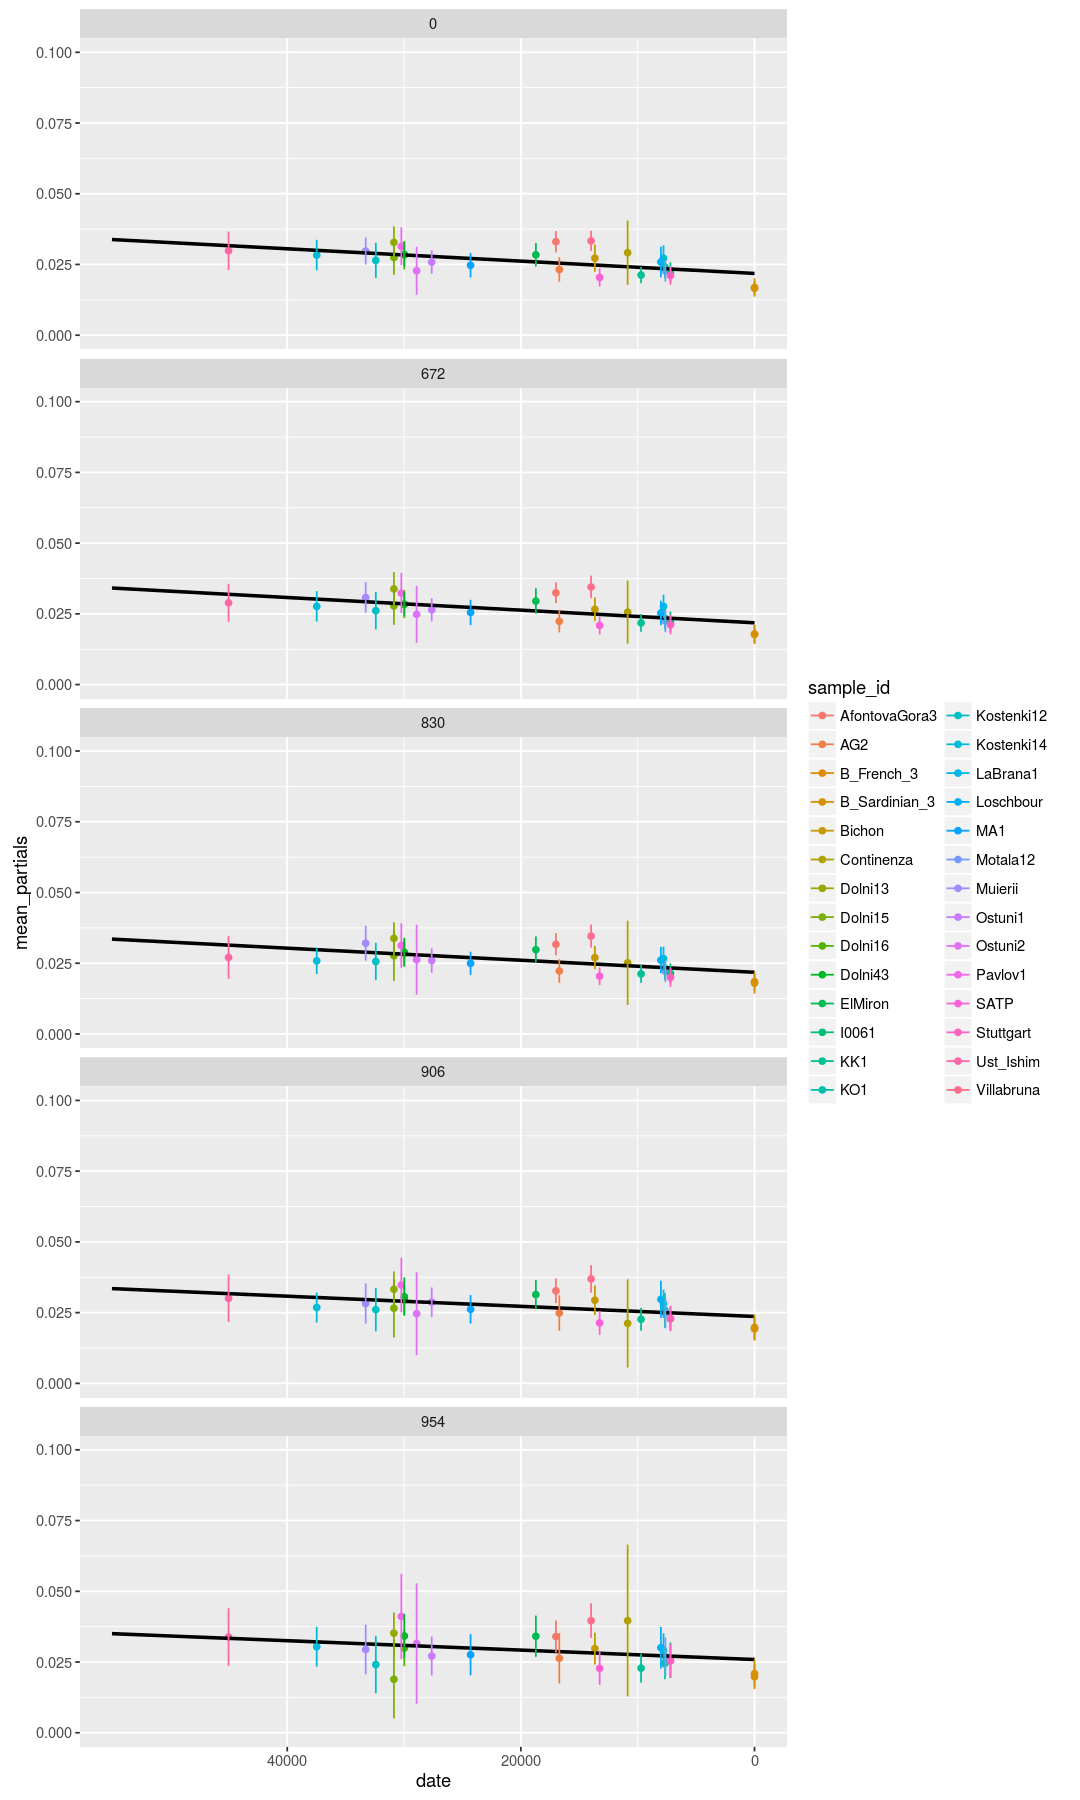

In [82]:
ggplot(filter(nea_estimates_cumul, sample_id != "Oase1_d"), aes(x=date, y=mean_partials, color=sample_id)) +
    geom_point() +
    geom_smooth(method="lm", col="black", se=FALSE, fullrange=TRUE) +
    geom_errorbar(aes(ymin=paper_ci_low, ymax=paper_ci_up)) +
    facet_wrap(~bin, ncol=1) +
    scale_x_reverse(lim=c(55000, 0)) +
    ylim(0, 0.1)

## Nea% over time in different B value bins

In [83]:
nea_estimates_bins <- read.table("../results/nea_estimates_b_bins.tsv", header=TRUE, stringsAsFactors=FALSE)

In [84]:
options(repr.plot.width=9, repr.plot.height=15)

### Jackknife from the paper

Warning message:
: Removed 1 rows containing missing values (geom_errorbar).

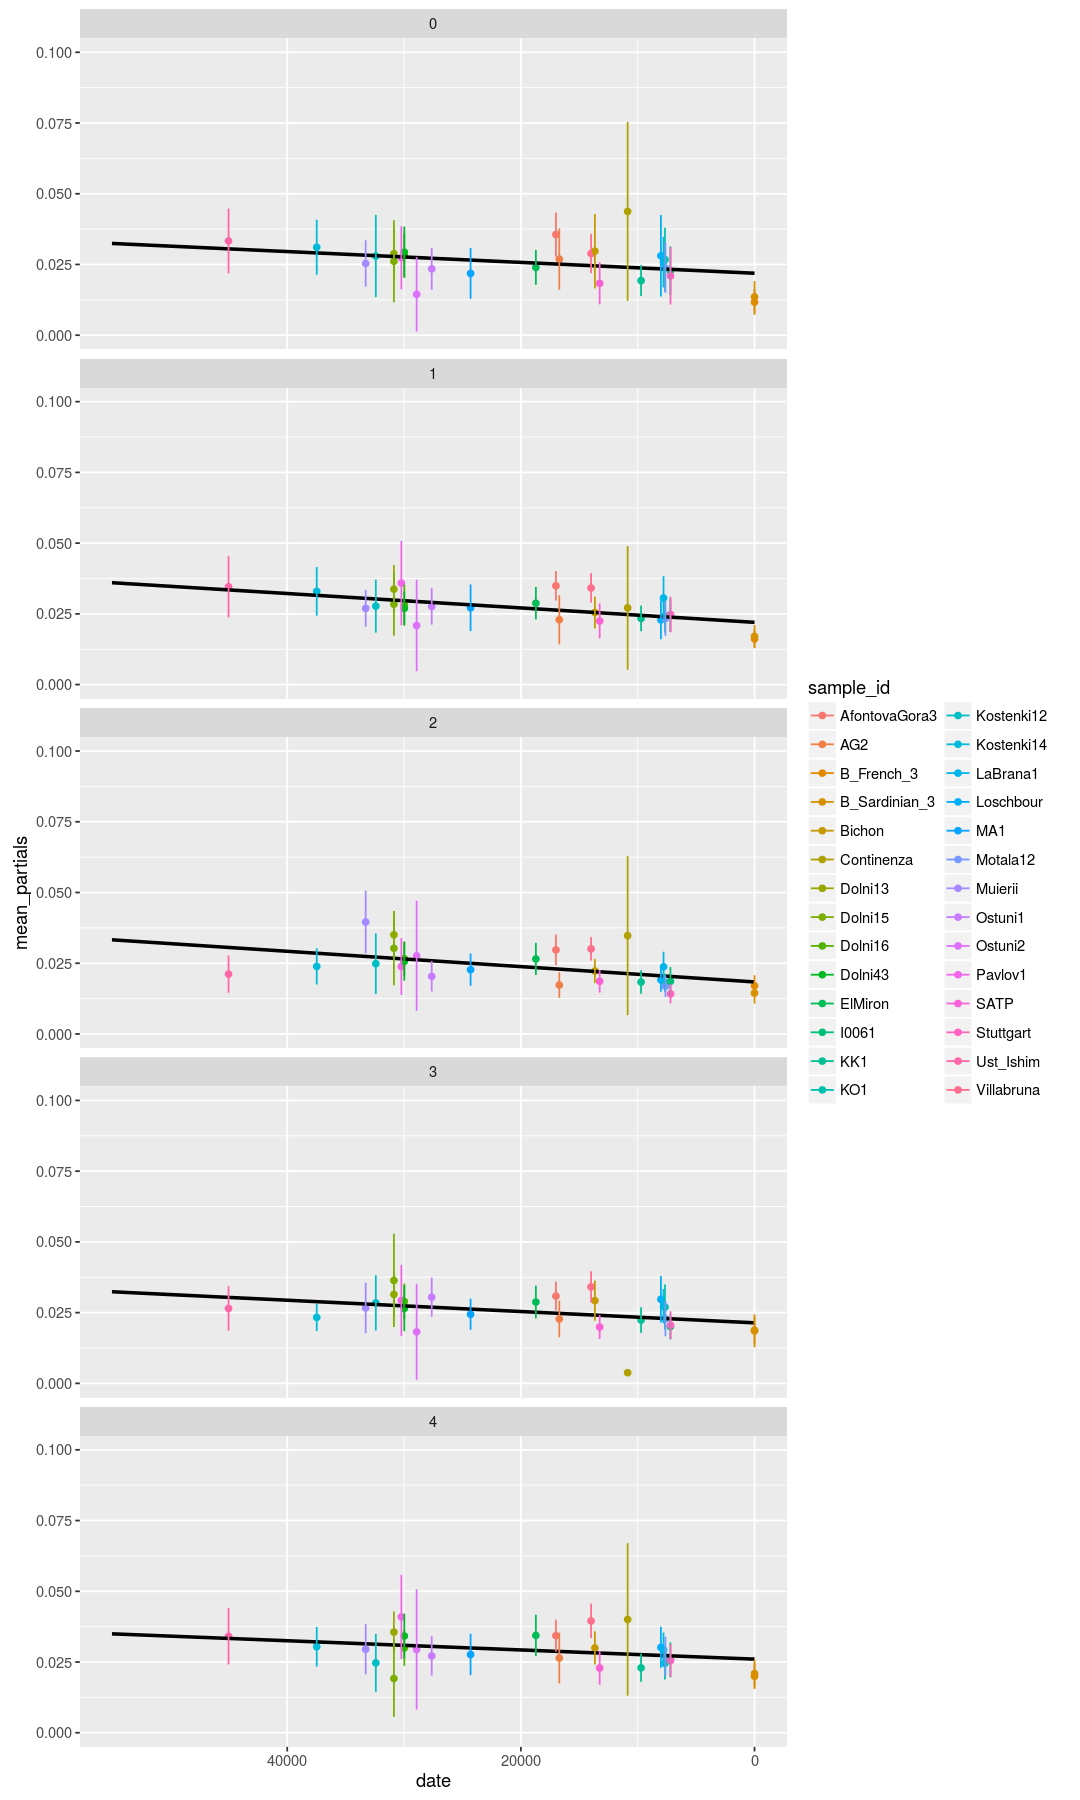

In [85]:
ggplot(filter(nea_estimates_bins, sample_id != "Oase1_d"), aes(x=date, y=mean_partials, color=sample_id)) +
    geom_point() +
    geom_smooth(method="lm", col="black", se=FALSE, fullrange=TRUE) +
    geom_errorbar(aes(ymin=paper_ci_low, ymax=paper_ci_up)) +
    facet_wrap(~bin, ncol=1) +
    scale_x_reverse(lim=c(55000, 0)) +
    ylim(0, 0.1)